## Inspect Prediction Results

In this notebook, we loop over all classification task predictions to detect where and how PrivBERT and other models differ in their predictions.

In [1]:
import json
import os
from collections import Counter
from copy import deepcopy
from itertools import product

import matplotlib
import pandas as pd
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_col,
    ggplot,
    labs,
    scale_fill_brewer,
    theme,
    theme_bw,
)
from tqdm import tqdm

%matplotlib inline
matplotlib.rc("text", usetex=True)

In [2]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base": "RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT",
}

TASKS = {
    "opp_115": "\\textbf{OPP-115}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "privacy_qa": "\\textbf{PrivacyQA}",
}


RANDOM_SEED_ITERATIONS = 10

# collect all predictions in dictionary
predictions = {}
for model in MODELS.keys():
    predictions[model] = {}
    for task in TASKS.keys():
        predictions[model][task] = []
        for index in range(RANDOM_SEED_ITERATIONS):
            with open(
                os.path.join(
                    "..", "runs", model, task, f"seed_{index}", "predictions.json"
                ),
                "r",
            ) as input_file_stream:
                preds = json.load(input_file_stream)
                predictions[model][task].append(preds)

Now we perform comparisons of predictions on PrivBERT vs. all other models and aggregate results.

In [3]:
# create storage variables and priv_bert predictions
comparisons = {}
interesting_example_ids = {}
priv_bert = predictions["mukund_privbert"]

# loop across all models that are not PrivBERT
for model in tqdm(MODELS.keys()):
    if model != "mukund_privbert":
        other_model = predictions[model]
        comparisons[("mukund_privbert", model)] = {}
        interesting_example_ids[("mukund_privbert", model)] = {}

        # loop across relevant tasks
        for task in TASKS.keys():
            priv_bert_task = priv_bert[task]
            other_model_task = other_model[task]
            interesting_example_ids[("mukund_privbert", model)][task] = {
                "priv_correct": [],
                "priv_wrong": [],
            }
            maybe_sort = sorted if task == "opp_115" else lambda x: x
            quadrant = []

            # loop across all seed combinations
            for seed_priv_bert, seed_other_model in product(
                range(RANDOM_SEED_ITERATIONS), range(RANDOM_SEED_ITERATIONS)
            ):
                priv_correct = []
                priv_wrong = []
                predictions_priv_bert = priv_bert_task[seed_priv_bert]
                predictions_other_model = other_model_task[seed_other_model]
                quadrant_seed = []

                # loop across all examples per seed combination
                for prediction_priv_bert, prediction_other_model in zip(
                    predictions_priv_bert, predictions_other_model
                ):
                    # make sanity checks
                    assert prediction_priv_bert["id"] == prediction_other_model["id"]
                    assert (
                        prediction_priv_bert["gold_label"]
                        == prediction_other_model["gold_label"]
                    )

                    # get necessary booleans
                    priv_bert_correct = maybe_sort(
                        prediction_priv_bert["predicted_label"]
                    ) == maybe_sort(prediction_priv_bert["gold_label"])
                    other_model_correct = maybe_sort(
                        prediction_other_model["predicted_label"]
                    ) == maybe_sort(prediction_other_model["gold_label"])

                    # increment frequency counts
                    if priv_bert_correct and other_model_correct:
                        quadrant_seed.append(1)
                    elif priv_bert_correct and not other_model_correct:
                        quadrant_seed.append(2)
                        priv_correct.append(prediction_priv_bert["id"])
                    elif not priv_bert_correct and other_model_correct:
                        quadrant_seed.append(3)
                        priv_wrong.append(prediction_priv_bert["id"])
                    else:
                        quadrant_seed.append(4)

                # collect quadrant_seed
                quadrant.append(quadrant_seed)

                # save collections into larger list
                interesting_example_ids[("mukund_privbert", model)][task][
                    "priv_correct"
                ].append(set(priv_correct))
                interesting_example_ids[("mukund_privbert", model)][task][
                    "priv_wrong"
                ].append(set(priv_wrong))

            # collect unique number of quadrant shifts
            comparisons[("mukund_privbert", model)][task] = dict(
                Counter(list(map(frozenset, (zip(*quadrant)))))
            )

            # perform intersection of comparisons
            interesting_example_ids[("mukund_privbert", model)][task][
                "priv_correct"
            ] = set.intersection(
                *interesting_example_ids[("mukund_privbert", model)][task][
                    "priv_correct"
                ]
            )
            interesting_example_ids[("mukund_privbert", model)][task][
                "priv_wrong"
            ] = set.intersection(
                *interesting_example_ids[("mukund_privbert", model)][task]["priv_wrong"]
            )

100%|██████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.87s/it]


Now we compile results into a pandas dataframe.

In [71]:
# consolidate dataframe
df = (
    pd.DataFrame.from_dict(comparisons)
    .melt(var_name=["first_model", "second_model"], ignore_index=False)
    .reset_index()
    .rename(columns={"index": "task"})
)

# make small adjustments
df["second_model"] = pd.Categorical(
    df["second_model"].replace(MODELS), list(MODELS.values())
)
df["task"] = df["task"].replace(TASKS)
hold = df["value"].apply(pd.Series)
df = pd.concat([df.drop("value", axis=1), hold.div(hold.sum(axis=1), axis=0)], axis=1)
df = df.melt(id_vars=["task", "second_model", "first_model"])
df = df.fillna(0)
df["variable"] = df["variable"].apply(
    lambda x: "(" + ", ".join([str(stuff) for stuff in x]) + ")"
)
maybe_sum = lambda x: sum(x) if isinstance(x, tuple) else x  # noqa: E731
df["variable"] = pd.Categorical(
    df["variable"],
    list(
        reversed(
            sorted(
                df["variable"].unique().tolist(),
                key=lambda x: len(x) + maybe_sum(eval(x)),
            )
        )
    ),
)
df = df.infer_objects()

In [70]:
df

,task,second_model,first_model,variable,value
0,\textbf{OPP-115},BERT,mukund_privbert,(1),0.591105
1,\textbf{Policy-Detection},BERT,mukund_privbert,(1),0.805627
2,\textbf{PolicyIE-A},BERT,mukund_privbert,(1),0.670509
3,\textbf{PrivacyQA},BERT,mukund_privbert,(1),0.852003
4,\textbf{OPP-115},RoBERTa,mukund_privbert,(1),0.591105
...,...,...,...,...,...
139,\textbf{PrivacyQA},Legal-BERT,mukund_privbert,(3),0.000016
140,\textbf{OPP-115},Legal-RoBERTa,mukund_privbert,(3),0.000000
141,\textbf{Policy-Detection},Legal-RoBERTa,mukund_privbert,(3),0.000000
142,\textbf{PolicyIE-A},Legal-RoBERTa,mukund_privbert,(3),0.000000


Now we plot our results.

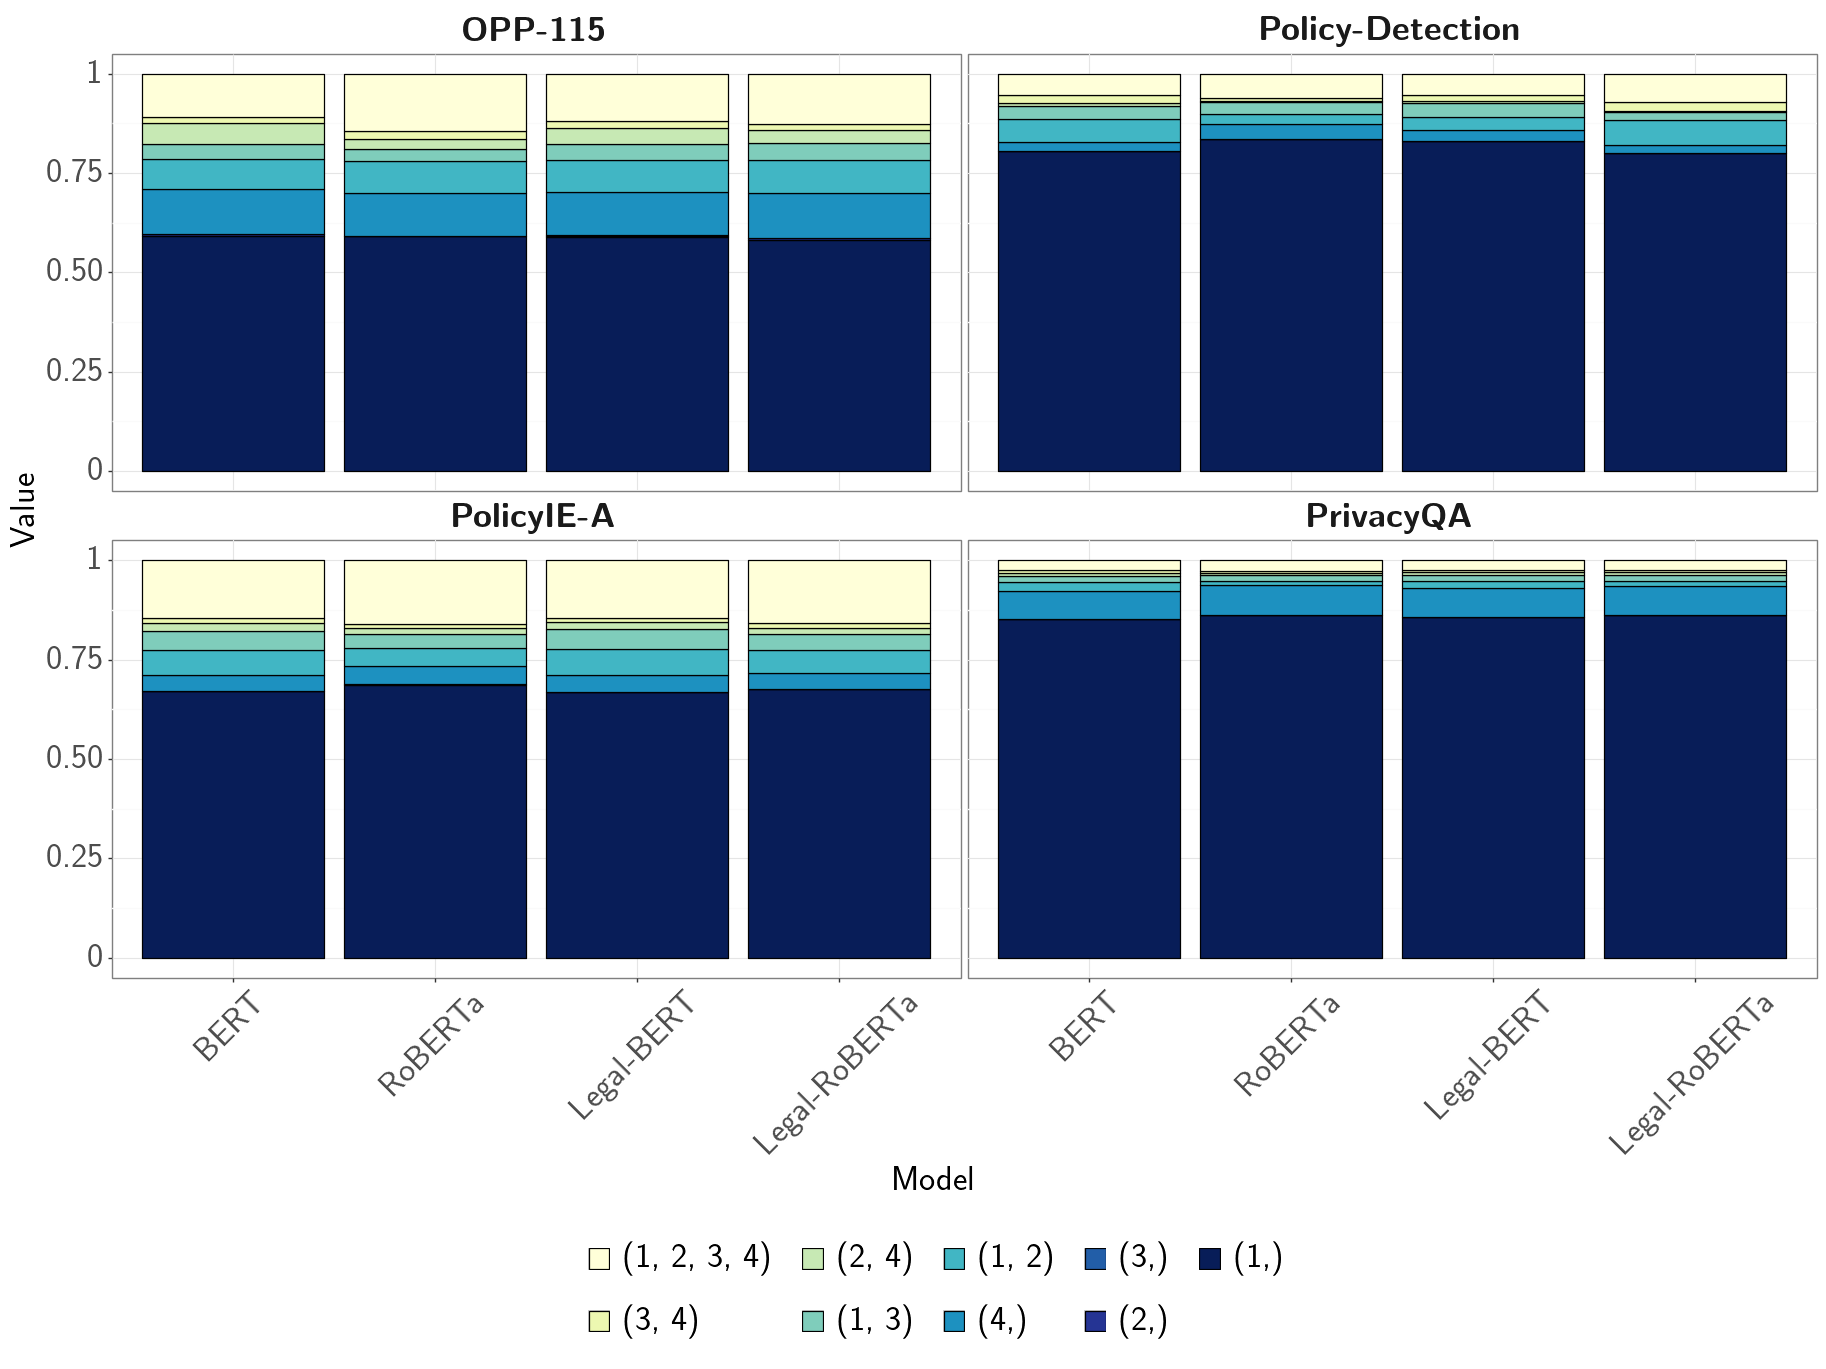

In [6]:
(
    ggplot(df, aes(x="second_model", y="value", fill="variable"))
    + geom_col(color="black")
    + facet_wrap("task")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45),
        figure_size=(22, 12),
        text=element_text(size=25),
        legend_text=element_text(margin={"l": 10}),
        legend_position=(0.5, -0.15),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_entry_spacing=20,
        strip_background=element_blank(),
    )
    + scale_fill_brewer("seq", 16)
    + labs(x="Model", y="Value")
).draw();

Finally, we inspect some interesting examples where models disagreed regardless of random seeds used for initialization.

In [7]:
interesting_example_ids

{('mukund_privbert',
  'bert_base_uncased'): {'opp_115': {'priv_correct': {47, 336, 511},
   'priv_wrong': set()}, 'policy_detection': {'priv_correct': set(),
   'priv_wrong': set()}, 'policy_ie_a': {'priv_correct': {1000},
   'priv_wrong': set()}, 'privacy_qa': {'priv_correct': {30379, 37585, 49394},
   'priv_wrong': {10700, 11744, 14210, 14231, 19842, 47271}}},
 ('mukund_privbert',
  'roberta_base'): {'opp_115': {'priv_correct': set(),
   'priv_wrong': set()}, 'policy_detection': {'priv_correct': set(),
   'priv_wrong': set()}, 'policy_ie_a': {'priv_correct': {647},
   'priv_wrong': set()}, 'privacy_qa': {'priv_correct': set(),
   'priv_wrong': set()}},
 ('mukund_privbert',
  'nlpaueb_legal_bert_base_uncased'): {'opp_115': {'priv_correct': {15,
    241,
    336},
   'priv_wrong': {385}}, 'policy_detection': {'priv_correct': set(),
   'priv_wrong': set()}, 'policy_ie_a': {'priv_correct': set(),
   'priv_wrong': set()}, 'privacy_qa': {'priv_correct': {12312, 48482},
   'priv_wrong': {3

In [8]:
# TODO: get better examples from groups -> then break and start writing


def get_interesting_examples(interesting_example_ids):
    # copy input dictionary to get skeleton
    interesting_examples = deepcopy(interesting_example_ids)

    # loop across model pairs
    for (priv_bert, other_model), tasks in interesting_example_ids.items():

        # loop across tasks
        for task, split_ids in tasks.items():

            # loop across disagreement type
            for split, ids in split_ids.items():

                # create new dictionary leaf to fill up
                interesting_examples[(priv_bert, other_model)][task][split] = {}

                # loop across flagging indices
                for index in ids:

                    # create collection per flagging index
                    collection_priv_bert = []
                    collection_other_model = []

                    # loop across all random seeds and collect indices
                    for predictions_priv_bert, predictions_other_model in zip(
                        predictions[priv_bert][task], predictions[other_model][task]
                    ):
                        assert predictions_priv_bert[index]["id"] == index
                        collection_priv_bert.append(predictions_priv_bert[index])
                        collection_other_model.append(predictions_other_model[index])

                    # append examples into new dictionary
                    interesting_examples[(priv_bert, other_model)][task][split][
                        index
                    ] = [collection_priv_bert, collection_other_model]

    return interesting_examples

In [9]:
interesting_examples = get_interesting_examples(interesting_example_ids)

In [10]:
interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")]["opp_115"]

{'priv_correct': {336: [[{'id': 336,
     'text': 'Cookies will: Block the repeated delivery of the survey either in the current visit or in any subsequent visit Record only that the visitor had the opportunity to answer the survey questions Expire 60 days after being set Reduce the burden on visitors to the site by avoiding repeated delivery of the pop-up survey ',
     'gold_label': ['First Party Collection/Use'],
     'predicted_label': ['First Party Collection/Use']},
    {'id': 336,
     'text': 'Cookies will: Block the repeated delivery of the survey either in the current visit or in any subsequent visit Record only that the visitor had the opportunity to answer the survey questions Expire 60 days after being set Reduce the burden on visitors to the site by avoiding repeated delivery of the pop-up survey ',
     'gold_label': ['First Party Collection/Use'],
     'predicted_label': ['First Party Collection/Use']},
    {'id': 336,
     'text': 'Cookies will: Block the repeated deli

In [11]:
interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")][
    "policy_detection"
]

{'priv_correct': {}, 'priv_wrong': {}}

In [12]:
interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")][
    "policy_ie_a"
]

{'priv_correct': {}, 'priv_wrong': {}}

In [13]:
interesting_examples[("mukund_privbert", "nlpaueb_legal_bert_base_uncased")][
    "privacy_qa"
]

{'priv_correct': {12312: [[{'id': 12312,
     'question': 'do you use my data to modify the app',
     'text': 'Provide our services.',
     'gold_label': 'Relevant',
     'predicted_label': 'Relevant'},
    {'id': 12312,
     'question': 'do you use my data to modify the app',
     'text': 'Provide our services.',
     'gold_label': 'Relevant',
     'predicted_label': 'Relevant'},
    {'id': 12312,
     'question': 'do you use my data to modify the app',
     'text': 'Provide our services.',
     'gold_label': 'Relevant',
     'predicted_label': 'Relevant'},
    {'id': 12312,
     'question': 'do you use my data to modify the app',
     'text': 'Provide our services.',
     'gold_label': 'Relevant',
     'predicted_label': 'Relevant'},
    {'id': 12312,
     'question': 'do you use my data to modify the app',
     'text': 'Provide our services.',
     'gold_label': 'Relevant',
     'predicted_label': 'Relevant'},
    {'id': 12312,
     'question': 'do you use my data to modify the app